In [1]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../src')


import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data.preprocess import extend_market_data

# Define ticker symbols for corn and ethanol futures
corn_ticker = "ZC=F"   # Corn Futures (CBOT)
ethanol_ticker = "ZS=F"  # Ethanol Futures (NYMEX)
corn = yf.Ticker(corn_ticker)
ethanol = yf.Ticker(ethanol_ticker)
corn_data = corn.history(start ="2014-01-01", end ="2024-12-31")
ethanol_data = ethanol.history(start ="2014-01-01", end ="2024-12-31")

corn_data = extend_market_data(corn_data)
ethanol_data = extend_market_data(ethanol_data)


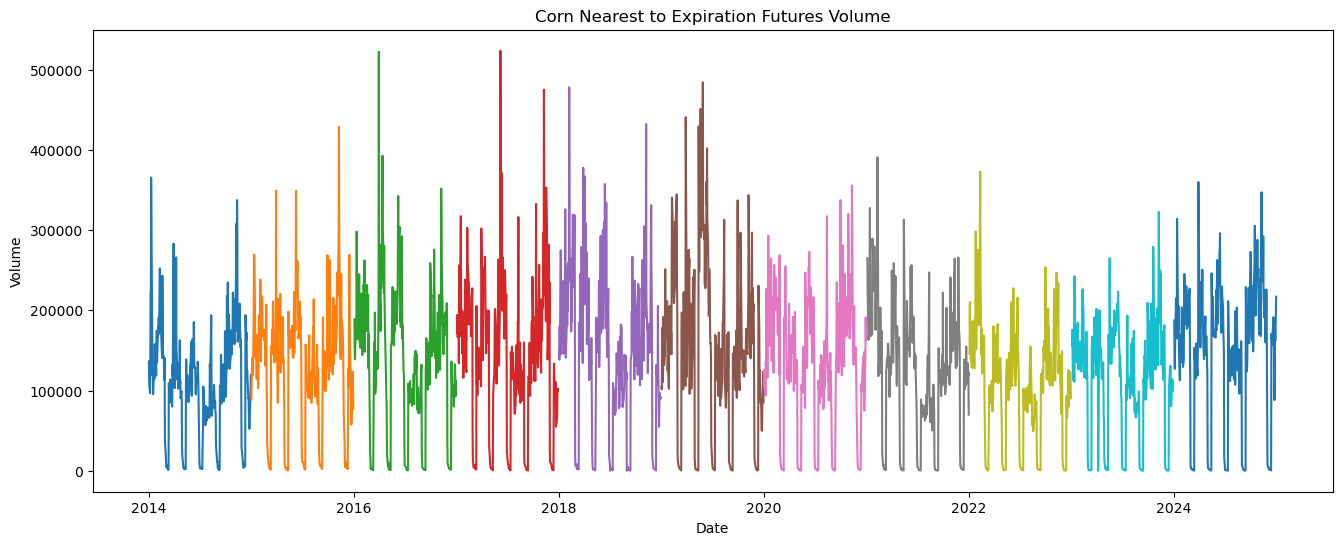

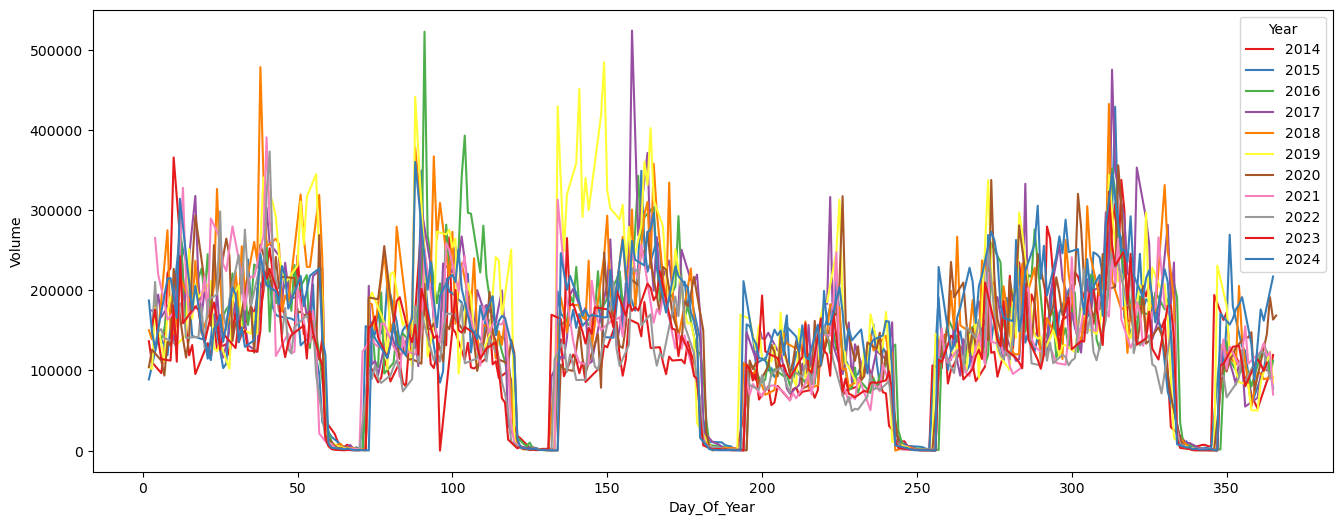

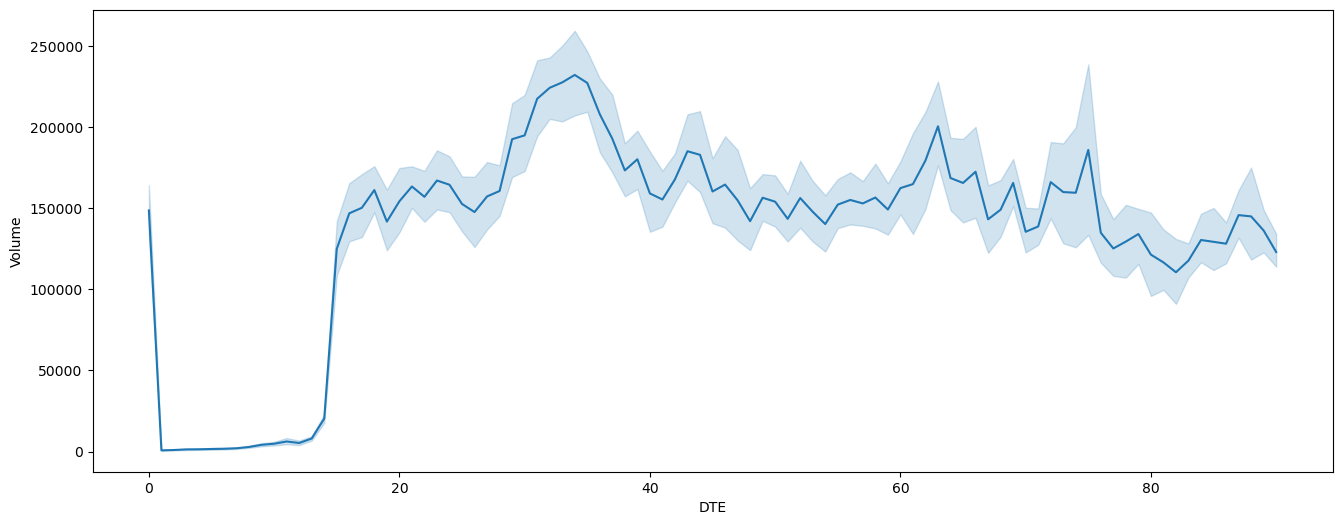

In [2]:
plt.figure(figsize = (16,6))
plt.title("Corn Nearest to Expiration Futures Volume")
for year in corn_data['Year'].unique():  # Loop through each unique year
    yearly_data = corn_data[corn_data['Year'] == year]
    sns.lineplot(x = 'Date', y = 'Volume', data = yearly_data)
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(x = 'Day_Of_Year', y = 'Volume', data = corn_data, hue ='Year', palette='Set1')
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(x = 'DTE', y = 'Volume', data = corn_data)
plt.show()

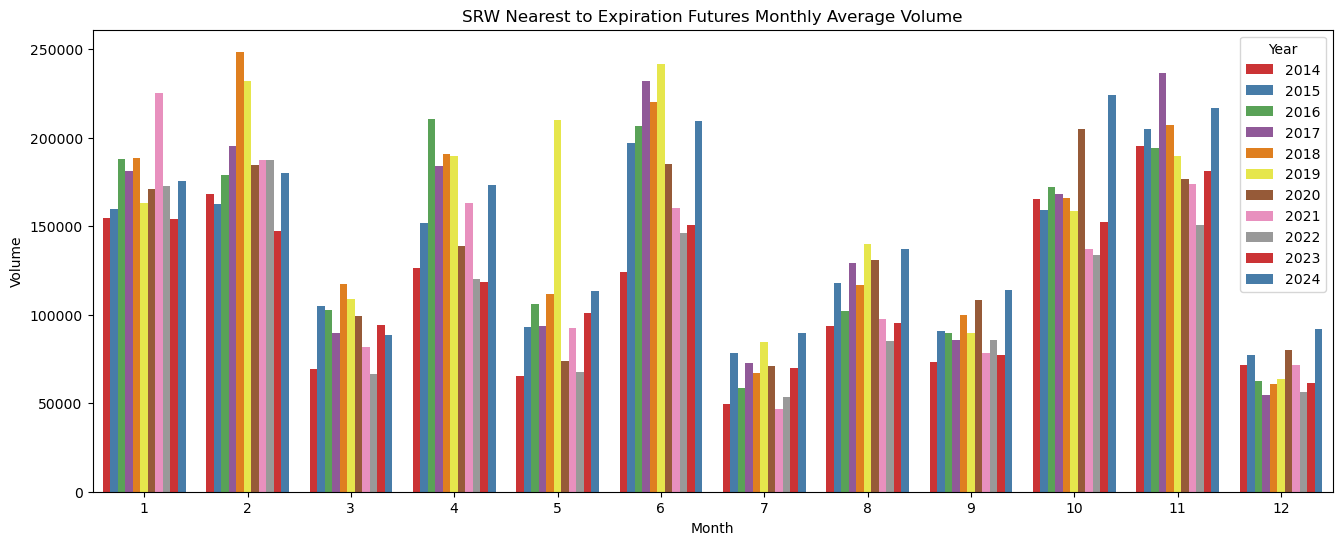

In [3]:
monthly_average = corn_data.groupby(['Year', 'Month']).Volume.agg('mean').reset_index()

plt.figure(figsize = (16,6))
plt.title("SRW Nearest to Expiration Futures Monthly Average Volume")
sns.barplot(x = 'Month', y = 'Volume', data = monthly_average, hue = 'Year', palette='Set1')
# sns.barplot(x = 'Month', y = 'Volume', data = monthly_average)
plt.show()

The trading volume in March, May, July, September, and December are low, which is expected as these are the expiration dates of corn futures. However, August trading volume is also low, relative to the other months. 

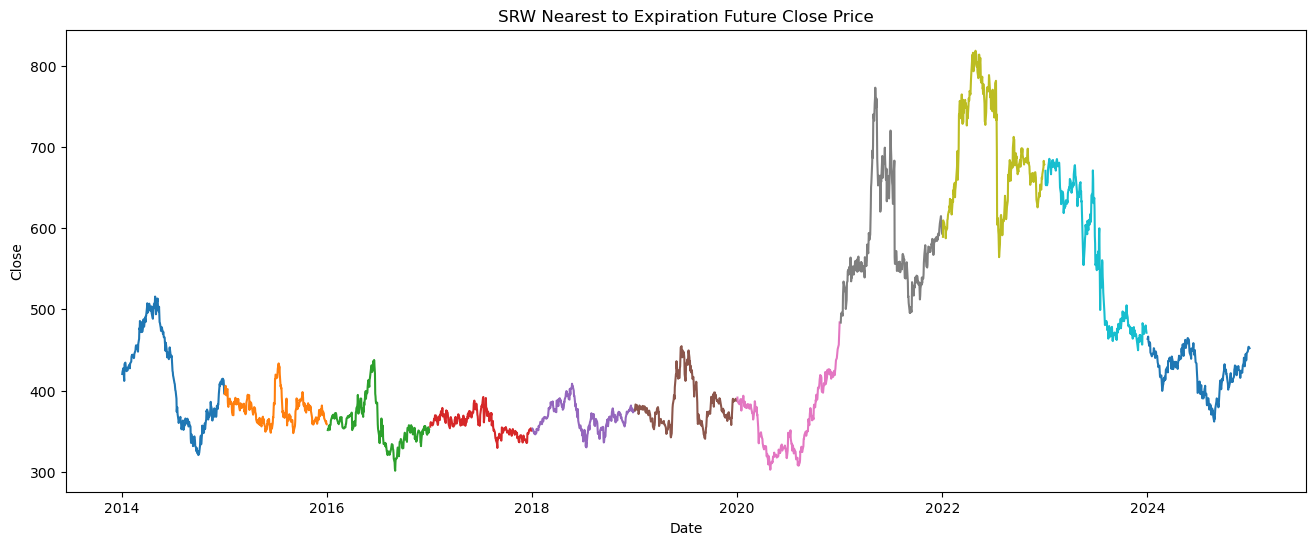

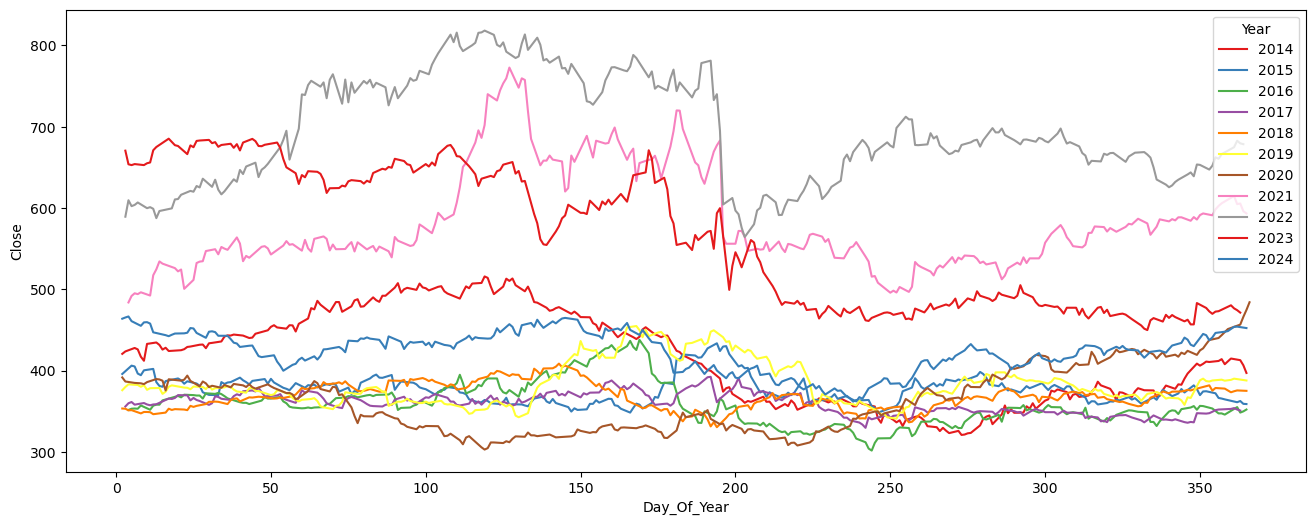

In [4]:
plt.figure(figsize = (16,6))
plt.title("SRW Nearest to Expiration Future Close Price")
for year in corn_data['Year'].unique():  # Loop through each unique year
    yearly_data = corn_data[corn_data['Year'] == year]
    sns.lineplot(x = 'Date', y = 'Close', data = yearly_data)
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(x = 'Day_Of_Year', y = 'Close', data = corn_data, hue ='Year', palette='Set1')
plt.show()

count    2762.000000
mean        0.000026
std         0.016184
min        -0.190997
25%        -0.008552
50%         0.000000
75%         0.008789
max         0.077178
Name: Log_Return, dtype: float64


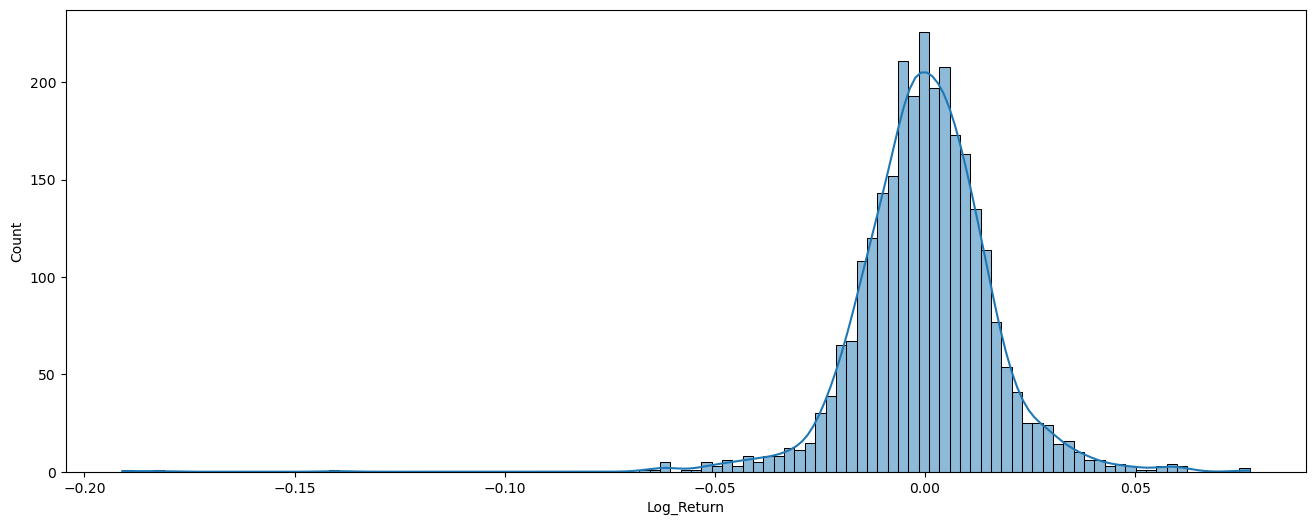

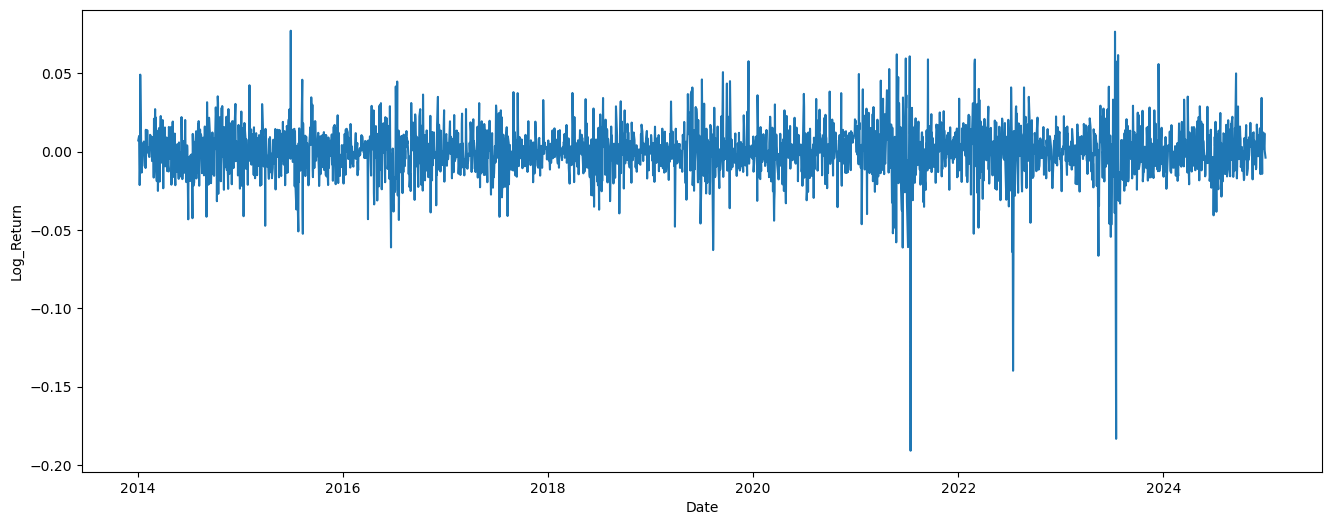

In [5]:
plt.figure(figsize = (16,6))
sns.histplot(corn_data['Log_Return'], kde = True)
print(corn_data['Log_Return'].describe())
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(corn_data['Log_Return'])
plt.show()

There's tiny seasonality at around 250 days.

C:\Users\johng23\AppData\Local\Temp\ipykernel_7092\2532573388.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / frequencies, power)


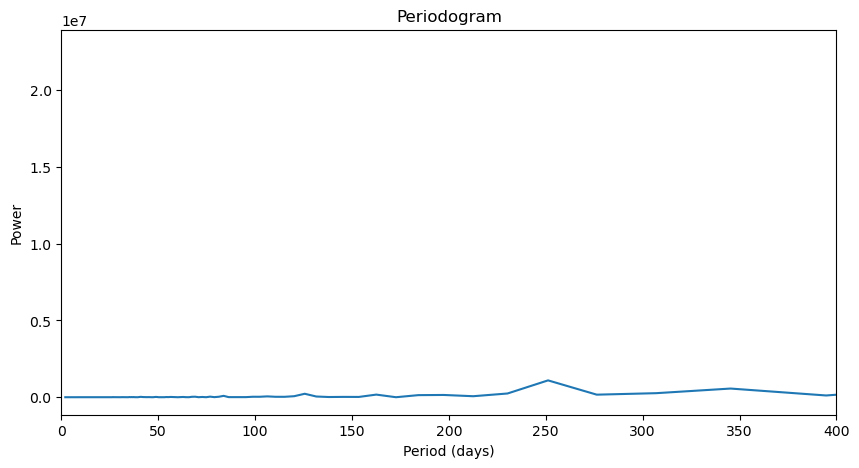

In [6]:
from scipy.signal import periodogram

frequencies, power = periodogram(corn_data['Close'].dropna())

plt.figure(figsize=(10, 5))
plt.plot(1 / frequencies, power)
plt.xlabel("Period (days)")
plt.ylabel("Power")
plt.title("Periodogram")
plt.xlim(0, 400)  # Limit x-axis to reasonable periods
plt.show()

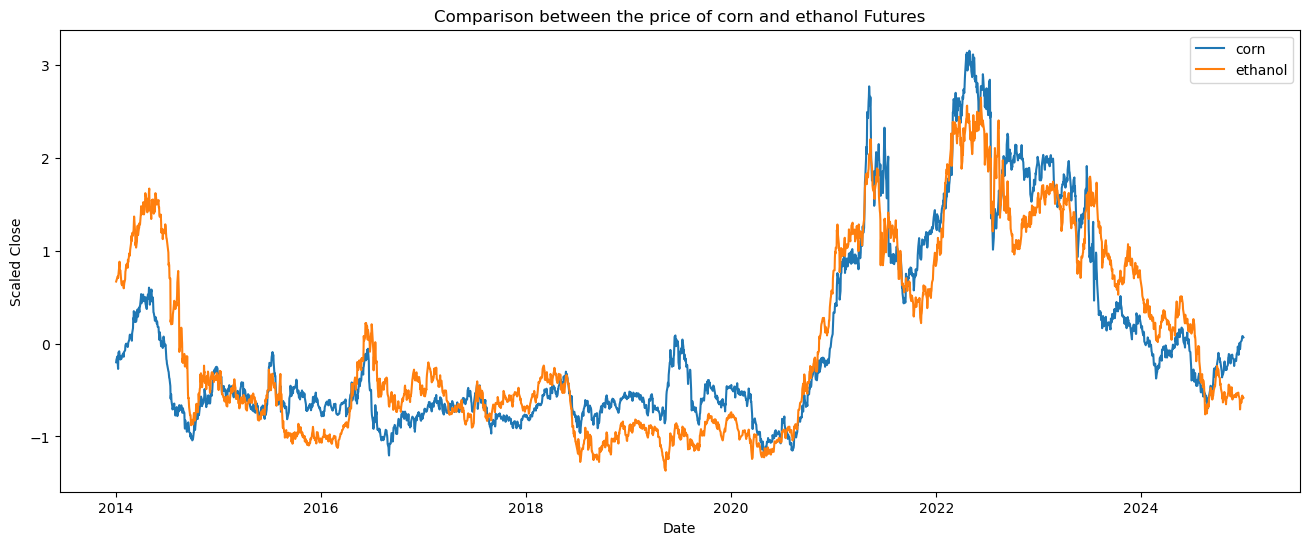

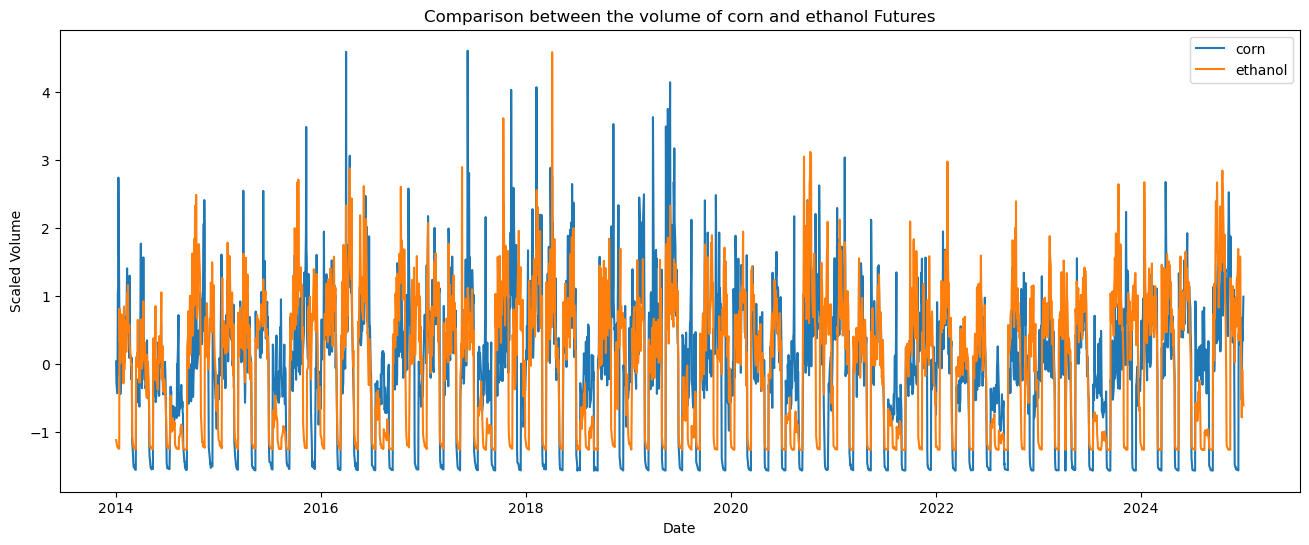

In [7]:


# corn_data["Scaled Close"] = corn_scaler.fit_transform(corn_data["Close"].to_frame())
# ethanol_data["Scaled Close"] = ethanol_scaler.fit_transform(ethanol_data["Close"].to_frame())


plt.figure(figsize=(16, 6))
plt.title("Comparison between the price of corn and ethanol Futures")
sns.lineplot(x = 'Date', y = 'Scaled Close', data = corn_data, label = "corn")
sns.lineplot(x = 'Date', y = 'Scaled Close', data = ethanol_data, label = "ethanol")
plt.show()

plt.figure(figsize=(16, 6))
plt.title("Comparison between the volume of corn and ethanol Futures")
sns.lineplot(x = 'Date', y = 'Scaled Volume', data = corn_data, label = "corn")
sns.lineplot(x = 'Date', y = 'Scaled Volume', data = ethanol_data, label = "ethanol")
plt.show()

In [76]:
import numpy as np
import xgboost as xgb
from sklearn.datasets import make_regression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

def obj(params):

    if 'n_estimators' in params.keys():
        params['n_estimators'] = int(params['n_estimators'])
    if 'max_depth' in params.keys():
        params['max_depth'] = int(params['max_depth'])
    
    
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
           'Year', 'Month', 'Day', 'Day_Of_Year', 'DTE', 'Log_Return',
           '7D_Volatility', '14D_Volatility', 'High-Low', 'High-Close',
           'Low-Close', 'TR', '14D_ATR', 'Volume_Volatility_Ratio', 'Scaled Close',
           'Scaled Volume', '14D_RSI', '7D_MA', '14D_MA', '7D_EMA', '14D_EMA']
    
    corn_data["Log_Return_Shift"] = corn_data["Log_Return"].shift(-1)
    corn_data2 = corn_data.dropna()
    X = corn_data2[features]
    y = corn_data2["Log_Return_Shift"]
    tss = TimeSeriesSplit(n_splits = 5)
    r2 = 0
    for i, (train_index, test_index) in enumerate(tss.split(X)):
        # print(f"Fold {i}:")
        # print(f"  Train: index={train_index}")
        # print(f"  Test:  index={test_index}")
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)
        # Set XGBoost parameters
        # params = {
        #     'objective': 'reg:squarederror',  # Regression
        #     'eval_metric': 'rmse',
        #     'max_depth': 1,
        #     'eta': 0.1,
        #     'n_estimators': 50,
        # }
        
        xgb_model = xgb.XGBRegressor(**params)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)
        
        # # Train the model
        # num_round = 50  # Number of boosting rounds
        # bst = xgb.train(params, dtrain, num_round)
        
        # # Make predictions
        # preds = bst.predict(dtest)
        
        # # Evaluate performance
        # mse = mean_squared_error(y_test, preds)
        # print(f'Mean Squared Error: {mse:.10f}')
        sc = r2_score(y_test, y_pred)
        r2 += r2_score(y_test, y_pred)
        # print(f"R² Score XGB: {sc:.4f}")
    
        # lin = LinearRegression()
        # lin.fit(X_train,y_train)
        # predlin = lin.predict(X_test)
        # r2 = r2_score(y_test, predlin)
        # print(f"R² Score Linear: {r2:.4f}")
    return -r2

In [2]:
# from hyperopt import fmin, tpe, hp
# # Define the hyperparameter space
# paramspace = {
#     'objective': 'reg:squarederror',  # Regression
#     'eval_metric': 'rmse',
#     'n_estimators': hp.quniform('n_estimators', 10,200,10),
#     'max_depth': hp.quniform('max_depth', 2, 8, 1),
#     'learning_rate': hp.loguniform('learning_rate', -5, -1),
#     'min_child_weight': hp.quniform('min_child_weight', 1, 100, 9),
#     'gamma': hp.quniform('gamma', 0, 5, 1),
#     'subsample': hp.uniform('subsample', .5, 1)
# }
# best_params = fmin(obj, paramspace, algo=tpe.suggest, max_evals=100)


In [9]:
import requests
import json

# def get_climate_data(sid):
#     url = "http://data.rcc-acis.org/StnData"
#     current_date = str(datetime.now().date())
#     start_date = str((datetime.now()-timedelta(days = 15*365)).date())
#     params = {
#         "sid": sid,  # Station ID
#         "sdate": start_date,  # Start date
#         "edate": current_date,  # End date
#         "elems":["maxt","mint","avgt","pcpn","snow"],
#         "output": "json"
#     }
    
#     response = requests.post(url, json=params)
    
#     if response.status_code == 200:
#         data = response.json()
#         return data
#     else:
#         print("Error fetching data:", response.status_code, response.text)
def get_climate_data(sid):
    url = "http://data.rcc-acis.org/StnData"
    current_date = str(datetime.now().date())
    start_date = str((datetime.now()-timedelta(days = 15*365)).date())
    params = {
        "sid": sid,  # Station ID
        "sdate": start_date,  # Start date
        "edate": current_date,  # End date
        "elems":["maxt","mint","avgt","pcpn","snow"],
        "output": "json"
    }
    
    response = requests.post(url, json=params)
    
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print("Error fetching data:", response.status_code, response.text)

In [10]:
import requests
import json
import pandas as pd
from geopy.distance import geodesic
from datetime import datetime
from datetime import timedelta

def fetch_station_metadata(state):
    url = "http://data.rcc-acis.org/StnMeta"
    # Get the current date and subtract 15 years
    current_date = str(datetime.now().date()-timedelta(days = 10))
    start_date = str((datetime.now()-timedelta(days = 15*365)).date())
    params = {
      "state":state,
      "elems":["maxt","mint","avgt","pcpn","snow"],
      "sdate":start_date,
      "edate":current_date,
      "meta":["name","state","sids","elev","ll","uid"]
    }
    response = requests.post(url, json=params)
    
    if response.status_code == 200:
        data = response.json()
        stations = []
        for station in data.get("meta", []):
            goodStation = True
            for ran in stations.get("valid_daterange"):
                if len(ran) == 0:
                    goodStation = False
                if datetime.fromisoformat(ran[0]) < start_date or datetime.fromisoformat(ran[1]) < current_date:
                    good_station = False
            if goodStation:
                stations.append({
                    "Name": station.get("name", "N/A"),
                    "ID(s)": ", ".join(station.get("sids", [])),
                    "Elevation (ft)": station.get("elev", "N/A"),
                    "Latitude": station.get("ll", [None, None])[1],
                    "Longitude": station.get("ll", [None, None])[0],
                })
            
        return pd.DataFrame(stations)
    else:
        print("Error fetching station metadata:", response.status_code, response.text)
        return pd.DataFrame()

# More specific locations in corn-producing areas
corn_belt_locations = [
    (40.1975, -91.1860),  # Keokuk, Iowa (known for high corn production)
    (41.5911, -93.6153),  # Des Moines, Iowa
    (39.7990, -88.8250),  # Champaign, Illinois
    (40.2230, -85.6690),  # Muncie, Indiana
    (41.7041, -93.6552),  # Story City, Iowa
    (43.5854, -96.7003),  # Sioux Falls, South Dakota
    (39.2223, -98.1743),  # Beloit, Kansas
    (44.7417, -92.9114)   # Red Wing, Minnesota
]

def find_nearest_stations():
    states = ["IA", "IL", "IN", "MO", "SD", "KS", "MN"]
    all_stations = pd.concat([fetch_station_metadata(state) for state in states], ignore_index=True)
    all_stations = all_stations.dropna()
    
    nearest_stations = []
    for lat, lon in corn_belt_locations:
        print(lat, lon)
        all_stations["Distance"] = all_stations.apply(
            lambda row: geodesic((lat, lon), (row["Latitude"], row["Longitude"])).miles, axis=1
        )
        nearest = all_stations.nsmallest(1, "Distance").iloc[0]
        nearest_stations.append({
            "Corn Location": (lat, lon),
            "Nearest Station": nearest["Name"],
            "Station ID(s)": nearest["ID(s)"],
            "Distance (miles)": nearest["Distance"]
        })
    
    nearest_df = pd.DataFrame(nearest_stations)
    return nearest_df


In [11]:
import requests
import json

def get_climate_data(date, state):
    url = "http://data.rcc-acis.org/MultiStnData"
    current_date = str(datetime.now().date())
    start_date = str((datetime.now()-timedelta(days = 15*1)).date())
    params = {
        # "sid": sid,  # Station ID
        # "sdate": start_date,  # Start date
        # "edate": current_date,  # End date
        "date": date,
        "state": state,
        "elems":["maxt","mint","avgt","pcpn","snow"],
        "output": "json"
    }
    
    response = requests.post(url, json=params)
    
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print("Error fetching data:", response.status_code, response.text)

In [12]:
d = get_climate_data("2025-03-01","IL")

In [13]:
lonlatlist = []
for i in range(len(d["data"])):
    if "ll" in d.get("data")[i]["meta"].keys():
        lonlatlist.append(d.get("data")[i]["meta"]["ll"])

In [1]:

import src.data.weather_script as ws
import rasterio
src = rasterio.open("../data/2023_30m_cdls.tif")
ws.getKNearestLocations(src, lonlatlist, 4, 10, 30, 1)

ModuleNotFoundError: No module named 'src'

In [65]:
current_date = str(datetime.now().date())
start_date = str((datetime.now()-timedelta(days = 15*365)).date())
params = {
  "state":"IL",
  "elems":["maxt","mint","avgt","pcpn","snow"],
  "sdate":start_date,
  "edate":current_date,
  "meta":["name","state","sids","elev","ll","uid","valid_daterange"]
}
response = requests.post(url, json=params)

In [68]:
response.json().get("valid_d

dict

In [71]:
datetime.fromisoformat("2015-01-02")

datetime.datetime(2015, 1, 2, 0, 0)

In [14]:
import sys
sys.path.insert(0, '..')
import src.data.weather_script as ws
import rasterio
src = rasterio.open("../data/2023_30m_cdls.tif")
ws.getKNearestLocations(src, lonlatlist, 4, 10, 30, 1)

0
1
2
3
4
5
6
7
8
9


[(442.0,
  [(0.0, (40.07678, -88.26666)),
   (1.0, (40.08081, -88.2602)),
   (1.0, (40.07807, -88.25366)),
   (1.4142135623730951, (40.08197, -88.25148))]),
 (1.0,
  [(0.0, (40.10667, -88.20398)),
   (1.0, (40.10586, -88.20148)),
   (1.0, (40.10281, -88.22266)),
   (1.4142135623730951, (40.0964, -88.19803))]),
 (4.0,
  [(1.0, (40.0763, -88.1908)),
   (1.4142135623730951, (40.08267, -88.20619)),
   (1.4142135623730951, (40.09634, -88.18016)),
   (1.4142135623730951, (40.0964, -88.19803))]),
 (263.0,
  [(1.4142135623730951, (40.07678, -88.26666)),
   (2.23606797749979, (40.08081, -88.2602)),
   (2.0, (40.08197, -88.25148)),
   (2.23606797749979, (40.08408, -88.24039))]),
 (773.0,
  [(2.0, (40.08081, -88.2602)),
   (2.23606797749979, (40.05658, -88.24892)),
   (2.23606797749979, (40.08197, -88.25148)),
   (2.8284271247461903, (40.08408, -88.24039))]),
 (175.0,
  [(1.4142135623730951, (40.05658, -88.24892)),
   (2.23606797749979, (40.08408, -88.24039)),
   (2.23606797749979, (40.07807, -88